In [67]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM 

from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [68]:
def generate_data(path):
  # Function that splits training path and annotations in 2 different lists.
  _path = []
  _label = []
  with open(path) as _data:
    for line in _data:
      temp = np.array(line.split())
      _path.append(temp[0])
      _label.append(temp[1])
  return _path, _label

In [69]:
test_path, test_label = generate_data("/kaggle/input/hindi-words-dataset/test.txt")

In [70]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(113, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [78]:
act_model.load_weights('/kaggle/input/hindi-ocr-model/keras/hindi_ocr_model2/1/C_LSTM_best2.keras')

In [73]:
def pre_process_image(path):

  img = cv2.cvtColor(cv2.imread("/kaggle/input/hindi-words-dataset/HindiSeg/"+path), cv2.COLOR_BGR2GRAY)
  # img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
  ### actually returns h, w
  h, w = img.shape

  ### if height less than 32
  if h < 32:
    add_zeros = np.ones((32-h, w)) * 255
    img = np.concatenate((img, add_zeros))
    h = 32

  ## if width less than 128
  if w < 128:
    add_zeros = np.ones((h, 128-w)) * 255
    img = np.concatenate((img, add_zeros), axis=1)
    w = 128

  ### if width is greater than 128 or height greater than 32
  if w > 128 or h > 32:
    img = cv2.resize(img, (128, 32))


  img = np.expand_dims(img , axis = 2)

  # Normalize each image
  img = img / 255.

  return img

In [74]:
def predict_output(img):
    # Predict outputs using the pre-trained model
    prediction = act_model.predict(np.array([img]))
    
    # Use CTC decoder to get text
    out = K.get_value(K.ctc_decode(
        prediction,
        input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
        greedy=True
    )[0][0])

    # Decode the final text into a single string
    decoded_text = ''
    for x in out:
        for p in x:
            if int(p) != -1:
                decoded_text += char_list[int(p)]
    
    return decoded_text

In [10]:
# First, install Levenshtein if needed
!pip install Levenshtein

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 3.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 43.8 MB/s eta 0:00:0000:0100:01


In [75]:
import Levenshtein as lev

# Function to calculate Character Error Rate (CER)
def calculate_cer(predicted_text, true_text):
    # Get the Levenshtein distance between predicted and actual text
    edit_distance = lev.distance(predicted_text, true_text)
    
    # CER is calculated as the edit distance divided by the length of the actual text
    cer = edit_distance / len(true_text)
    
    return cer

In [89]:
from IPython.display import display
from random import randrange

# Create lists to store the predicted and actual text
y_pred = []
y_true = test_label # Assuming `test_label` contains the actual ground truth text

# Generate predictions and compute CER
cer_list = []
for i in range(50):

    index = randrange(len(val_path))
    # Pre-process the image and get the predicted text
    test_img = pre_process_image(test_path[index])
    predicted_text = predict_output(test_img)
    
    # Get the actual text
    actual_text = test_label[index]
    
    # Calculate CER
    cer = calculate_cer(predicted_text, actual_text)
    cer_list.append(cer)

    # Store predicted text for further analysis
    y_pred.append(predicted_text)
    
    print(predicted_text, y_true[index])
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
बरिटरा ब्रिटिश
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
पोस्टमार्टम पोस्टमार्टम
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
जाता जाता।
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
कुटनोतिक कूटनीतिक
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
लौटा लौटा
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
ठोकना ठोकना
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
स्तोरिंग स्टोरिंग
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
विवशताएं विवशताएं
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
अवस्था अवस्था
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
जाई-जईसयरा आईआईएफएम
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
हीटर हीटर
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
झईिों झाईयों
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
याने थाने
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
दीरिया दरिया
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
जाकिर ज़ाकिर
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
खमकक्ष समकक्ष
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
तीस तीस
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
बुलाती बुलाती
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
गज-दो-दल गज-दो-गज
1/1 ━━

In [90]:
average_cer = np.mean(cer_list)
print("Average Character Error Rate (CER):", average_cer)

Average Character Error Rate (CER): 0.16537012987012986


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


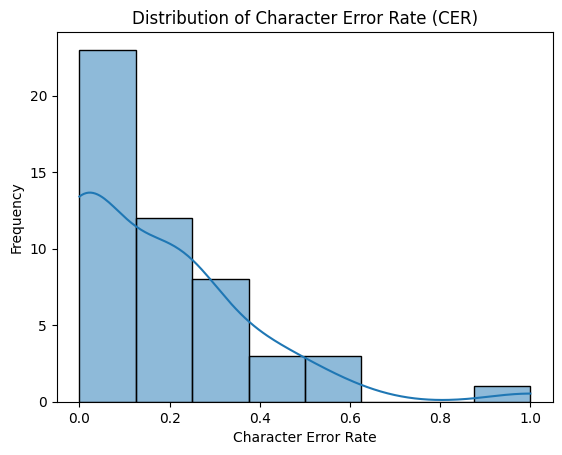

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Levenshtein import distance as levenshtein_distance

sns.histplot(cer_list, kde=True)
plt.title("Distribution of Character Error Rate (CER)")
plt.xlabel("Character Error Rate")
plt.ylabel("Frequency")
plt.show()